In [ ]:
import pandas as pd
import numpy as np
import torch
import pickle
from data_preprocessing import prepare_lstm_data  
from model import LSTMWithMLP

# Function to prepare LSTM input data
def lstm_data(data, scaler):
    data = data.copy()  # Ensure a deep copy to avoid SettingWithCopyWarning
    data['total_trips'] = data['total_trips'].astype('float64')
    data[['total_trips']] = scaler.transform(data[['total_trips']])
    X_tensor = torch.tensor(data['total_trips'].values, dtype=torch.float32).unsqueeze(-1)
    X_lstm = X_tensor.unsqueeze(0)
    return X_lstm


def inverse_normalize_count(data, scaler):
    data = data.numpy().reshape(-1, 1)  # Convert tensor to numpy array and reshape
    data = scaler.inverse_transform(data)
    data = np.round(data).astype(int)  # Convert to int to avoid dtype warning
    return data

# Function to load and prepare MLP input data
def prepare_mlp_input(df_mlp, hour):
    with open(r"C:\Users\yanzh\Desktop\code_and_data\4. Deep learning part\处理数据\scaler1.pkl", 'rb') as file:
        loaded_scaler1 = pickle.load(file)

    with open(r"C:\Users\yanzh\Desktop\code_and_data\4. Deep learning part\处理数据\scaler2.pkl", 'rb') as file:
        loaded_scaler2 = pickle.load(file)

    df_mlp['hour'] = df_mlp['date'].dt.hour
    df_mlp['month'] = df_mlp['date'].dt.month

    numeric_features1 = ['temperature_2m', 'CRASH COUNT']
    numeric_features2 = ['precipitation', 'rain', 'snowfall', 'snow_depth', 'wind_speed_10m']

    df_mlp[numeric_features1] = loaded_scaler1.transform(df_mlp[numeric_features1])
    df_mlp[numeric_features2] = loaded_scaler2.transform(df_mlp[numeric_features2])

    mlp_input = df_mlp[df_mlp['hour'] == hour].drop(columns='date')
    mlp_tensor = torch.tensor(mlp_input.values, dtype=torch.float32)

    return mlp_tensor

# Function to predict demand
def predict_demand(X_lstm, mlp_tensor, model, scaler):
    model.eval()
    with torch.no_grad():
        pi, sigma, mu = model(X_lstm, mlp_tensor)
    mu = inverse_normalize_count(mu, scaler).flatten()
    pi = pi.flatten()
    sigma = sigma.flatten()
    output = pd.DataFrame({
        'demand': mu,
        'probability': pi,
        'volatility': sigma
    })
    # max_demand = output.loc[output['probability'].idxmax(), 'demand']
    return output

In [ ]:
# Load data
path = r"C:\Users\yanzh\Desktop\code_and_data\4. Deep learning part\处理数据\2015-2019 total trips.csv"
df1 = pd.read_csv(path)
df1['date'] = pd.to_datetime(df1['date'])
df1['hour'] = df1['date'].dt.hour

initial_data = df1[df1['date'] >= pd.to_datetime('2019-12-31 00:00:00')].copy()  # Ensure a deep copy

mlp_path = r"C:\Users\yanzh\Desktop\code_and_data\4. Deep learning part\处理数据\2020-01-01_mlp.csv"
df_mlp = pd.read_csv(mlp_path)
df_mlp['date'] = pd.to_datetime(df_mlp['date'])


# Prepare LSTM scaler
_, lstm_scaler = prepare_lstm_data()

# Load the model
model = LSTMWithMLP(lstm_input_size=1, output_size=1, num_gaussians=5, mlp_input_dim=11)
state_path = r"C:\Users\yanzh\Desktop\code_and_data\4. Deep learning part\DL_hourly\final_model_state.pth"
model.load_state_dict(torch.load(state_path))

In [ ]:
all_predictions = []
max_demand_list = []
data = initial_data.tail(24)  # Initialize data for the first iteration

for hour in range(24):
    X_lstm = lstm_data(data, lstm_scaler)

    mlp_tensor = prepare_mlp_input(df_mlp, hour)

    predictions = predict_demand(X_lstm, mlp_tensor, model, lstm_scaler)
    max_demand = predictions['demand'][predictions['probability'].idxmax()]
    
    all_predictions.append(predictions)
    max_demand_list.append(max_demand)
    new_entry = pd.DataFrame({'date': [pd.to_datetime(f'2020-01-01 {hour}:00:00')], 'total_trips': [max_demand]})
    data = pd.concat([data, new_entry], ignore_index=True).tail(24)    

In [ ]:
# List comprehension to access multiple indices
selected_indices = [4, 9, 15, 18, 21]
selected_predictions = [all_predictions[i] for i in selected_indices]
selected_predictions

In [ ]:
max_demand_list

In [ ]:
import numpy as np
from scipy.stats import norm
results_dict = {}

for index, df in enumerate(selected_predictions):
    demands = df['demand'].values
    probabilities = df['probability'].values
    volatilities = df['volatility'].values

    # Normalize probabilities to ensure their sum is 1
    probabilities /= probabilities.sum()

    # Determine the range of integer values to evaluate based on demand and volatility
    min_value = int(np.floor(demands.min() - 3 * volatilities.max()))
    max_value = int(np.ceil(demands.max() + 3 * volatilities.max()))
    value_range = range(min_value, max_value + 1)

    # Initialize a dictionary to store cumulative probabilities for each integer value
    prob_dict = {val: 0 for val in value_range}
    for i, demand in enumerate(demands):
        for val in value_range:
            prob_dict[val] += probabilities[i] * norm.pdf(val, demand, volatilities[i])

    # Normalize the cumulative probabilities to sum to 1
    total_prob = sum(prob_dict.values())
    for val in prob_dict:
        prob_dict[val] /= total_prob

    # Store results
    most_probable_values = sorted(prob_dict, key=prob_dict.get, reverse=True)[:5]
    results_dict[index] = {val: f"{prob_dict[val]:.6f}" for val in most_probable_values}


In [ ]:
results_dict

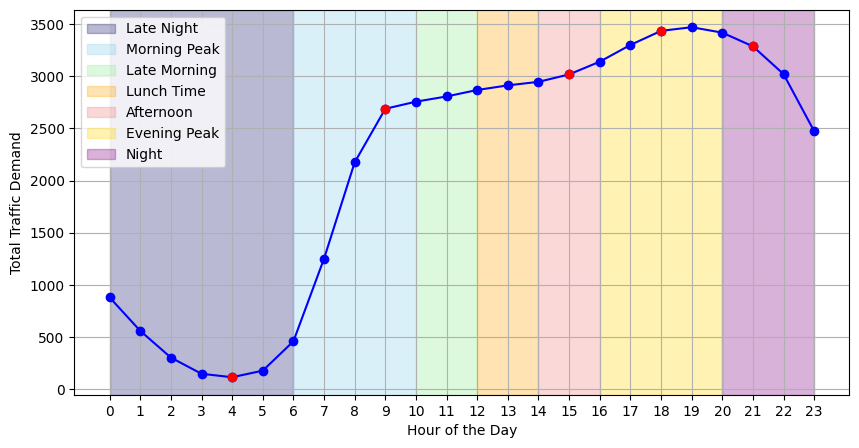

In [32]:
import matplotlib.pyplot as plt

# Data points
data = [880, 560, 304, 149, 116, 179, 460, 1252, 2174, 2687, 2755, 2805, 2867, 2911, 2945, 3016, 3138, 3298, 3433, 3468, 3416, 3285, 3019, 2472]

# Time points (0h to 1h)
time_points = [i for i in range(24)]

# Segments
segments = [
    ("Late Night", 0, 6, 'midnightblue'),
    ("Morning Peak", 6, 10, 'skyblue'),
    ("Late Morning", 10, 12, 'lightgreen'),
    ("Lunch Time", 12, 14, 'orange'),
    ("Afternoon", 14, 16, 'lightcoral'),
    ("Evening Peak", 16, 20, 'gold'),
    ("Night", 20, 23, 'purple')
]

# Plotting the data
plt.figure(figsize=(10, 5))

# Adding segments
for label, start, end, color in segments:
    plt.axvspan(start, end, color=color, alpha=0.3, label=label)

plt.plot(time_points, data, marker='o', color='blue')  # Keep line color blue

# Highlight specific points on the x-axis
highlight_points = [4, 9, 15, 18, 21]
for point in highlight_points:
    plt.plot(point, data[point], 'ro')  # Highlight the point with a red dot

# Adding titles and labels
# plt.title('Total traffic demand in Manhattan on January 1, 2020')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Traffic Demand')
plt.grid(True)

# Customizing the ticks
plt.xticks(time_points)  # Set x-ticks to every hour

# Adding legend
plt.legend(loc='upper left')

# Display the plot
plt.show()


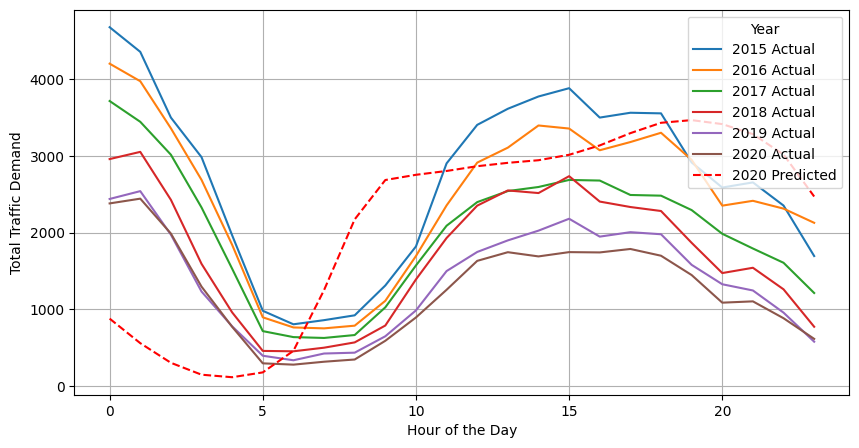

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is read correctly from the CSV
path = r"C:\Users\yanzh\Desktop\code_and_data\4. Deep learning part\处理数据\2015-2019 total trips.csv"
data = pd.read_csv(path)

data_2020 = [2382, 2444, 1989, 1297, 773, 297, 280, 318, 347, 591, 895, 1256, 1633, 1746, 1691, 1747, 1743, 1788, 1700, 1448, 1088, 1105, 885, 616]
predicted_2020 = [880, 560, 304, 149, 116, 179, 460, 1252, 2174, 2687, 2755, 2805, 2867, 2911, 2945, 3016, 3138, 3298, 3433, 3468, 3416, 3285, 3019, 2472]

# Create DataFrames for the actual and predicted data of 2020
df_2020 = pd.DataFrame({
    'date': [f'2020/1/1 {i}:00' for i in range(24)],
    'total_trips': data_2020,
    'predicted_trips': predicted_2020
})
df_2020['date'] = pd.to_datetime(df_2020['date'])  # Convert date to datetime type

# Append the 2020 DataFrame to the original 'data' DataFrame
data = pd.concat([data, df_2020], ignore_index=True)

# Convert 'date' column to datetime type if not already
data['date'] = pd.to_datetime(data['date'])

# Filter data for January 1st of each year
mask = (data['date'].dt.month == 1) & (data['date'].dt.day == 1)
filtered_df = data[mask]

# Create a plot figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot actual data for January 1st of each year from 2015 to 2020
for year in range(2015, 2021):
    # Select data for the specific year
    yearly_data = filtered_df[filtered_df['date'].dt.year == year]
    # Extract hour and total trips
    hourly_data = yearly_data.set_index(yearly_data['date'].dt.hour)['total_trips']
    # Plot a line graph for actual data
    ax.plot(hourly_data.index, hourly_data.values, label=str(year) + ' Actual')

# Plot predicted data for January 1st of 2020
predicted_data = df_2020.set_index(df_2020['date'].dt.hour)['predicted_trips']
ax.plot(predicted_data.index, predicted_data.values, label='2020 Predicted', linestyle='--', color='red')

# Add legend with title 'Year'
ax.legend(title='Year')

# Set title and labels for the axes
# ax.set_title('Total Traffic Demand on January 1st by Year (2015-2020), Predicted for January 1st, 2020')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Total Traffic Demand')
ax.grid()
# Display the plot
plt.show()
